# Hypertuning of parameters for DeepAR Estimator

### Imports and housekeeping

In [1]:
import sagemaker

from sagemaker.estimator import Estimator
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

### Helper functino to return a properly initiated DeepAR estimator

In [2]:
def deepar_estimator(prediction_length):
    image_name = get_image_uri(sagemaker_session.boto_region_name, 'forecasting-deepar')    
    estimator = Estimator(sagemaker_session=sagemaker_session,
                            image_name=image_name,
                            role=role,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            train_use_spot_instances=True,
                            train_max_wait=3600,
                            train_max_run=3600)
    
    hyperparameters_base = {
        "epochs": "250",
        "time_freq": 'W',
        "num_layers": "2",
        "early_stopping_patience": "25",
        'prediction_length': prediction_length,
        'num_dynamic_feat': 'auto',
        'cardinality': 'ignore'}
    
    estimator.set_hyperparameters(**hyperparameters_base)
    
    return estimator

### Hyperparameters search grid, objective metric and input definitions

In [3]:
objective_metric_name = 'test:RMSE'

hyperparameter_ranges_sj = {
    'dropout_rate': ContinuousParameter(0.01, 0.1),
    'learning_rate': ContinuousParameter(0.001, 0.1),
    'mini_batch_size': IntegerParameter(32, 128),
    'context_length': IntegerParameter(16, 256),
    'num_cells': IntegerParameter(32, 128)
}

hyperparameter_ranges_iq = {
    'dropout_rate': ContinuousParameter(0.01, 0.1),
    'learning_rate': ContinuousParameter(0.001, 0.1),
    'mini_batch_size': IntegerParameter(32, 128),
    'context_length': IntegerParameter(16, 256),
    'num_cells': IntegerParameter(32, 128)
}

In [4]:
data_channels_sj = {'train': 's3://sagemaker-eu-central-1-964501460451/dengai/2020-04-15--01-10-dew-std-label/pprocess_data/train_pp_sj.json',
                 'test' : 's3://sagemaker-eu-central-1-964501460451/dengai/2020-04-15--01-10-dew-std-label/pprocess_data/train_pp_sj.json' }
    
data_channels_iq = {'train': 's3://sagemaker-eu-central-1-964501460451/dengai/2020-04-15--01-10-dew-std-label/pprocess_data/train_test_pp_iq.json',
                 'test' : 's3://sagemaker-eu-central-1-964501460451/dengai/2020-04-15--01-10-dew-std-label/pprocess_data/train_test_pp_iq.json' }

### Estimator and hypertuning job instanciation

In [5]:
estimator_sj = deepar_estimator(260)
estimator_iq = deepar_estimator(156)

In [6]:
tuner_sj = HyperparameterTuner(estimator_sj,
                            objective_metric_name,
                            hyperparameter_ranges_sj,
                            max_jobs=250,
                            max_parallel_jobs=10,
                            objective_type='Minimize',
                            base_tuning_job_name='sj'
                            )
tuner_iq = HyperparameterTuner(estimator_iq,
                            objective_metric_name,
                            hyperparameter_ranges_iq,
                            max_jobs=250,
                            max_parallel_jobs=10,
                            objective_type='Minimize',
                            base_tuning_job_name='iq')

### Start and wait for the hypertuning jobs

In [7]:
tuner_sj.fit(data_channels_sj)
tuner_iq.fit(data_channels_iq)

In [ ]:
tuner_iq.wait()
tuner_sj.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Getting hypertuning job information and visualization

In [15]:
def analyze_ht_job(job_name):
    ht = HyperparameterTuner.attach(job_name)
    stats = ht.analytics().dataframe()
    print('Number of training jobs and parameters searched \n')
    print(stats.nunique())
    print('\n \n')
    
    stats_for_plot = stats[(stats.TrainingJobStatus=='Completed')].sort_values('FinalObjectiveValue')[:-5]
    best_ix = stats_for_plot.FinalObjectiveValue.idxmin()
    stats_for_plot.loc[best_ix]
    
    markers = ['.' for _ in range(len(stats_for_plot))]
    markers[0] = 'X'
    sns.pairplot(data=stats_for_plot, vars=ht._hyperparameter_ranges.keys(), hue='FinalObjectiveValue', palette='RdBu_r', markers=markers)

Number of training jobs and parameters searched 

context_length                116
dropout_rate                  191
learning_rate                 208
mini_batch_size                82
num_cells                      63
TrainingJobName               227
TrainingJobStatus               2
FinalObjectiveValue           176
TrainingStartTime             225
TrainingEndTime               225
TrainingElapsedTimeSeconds    213
dtype: int64

 



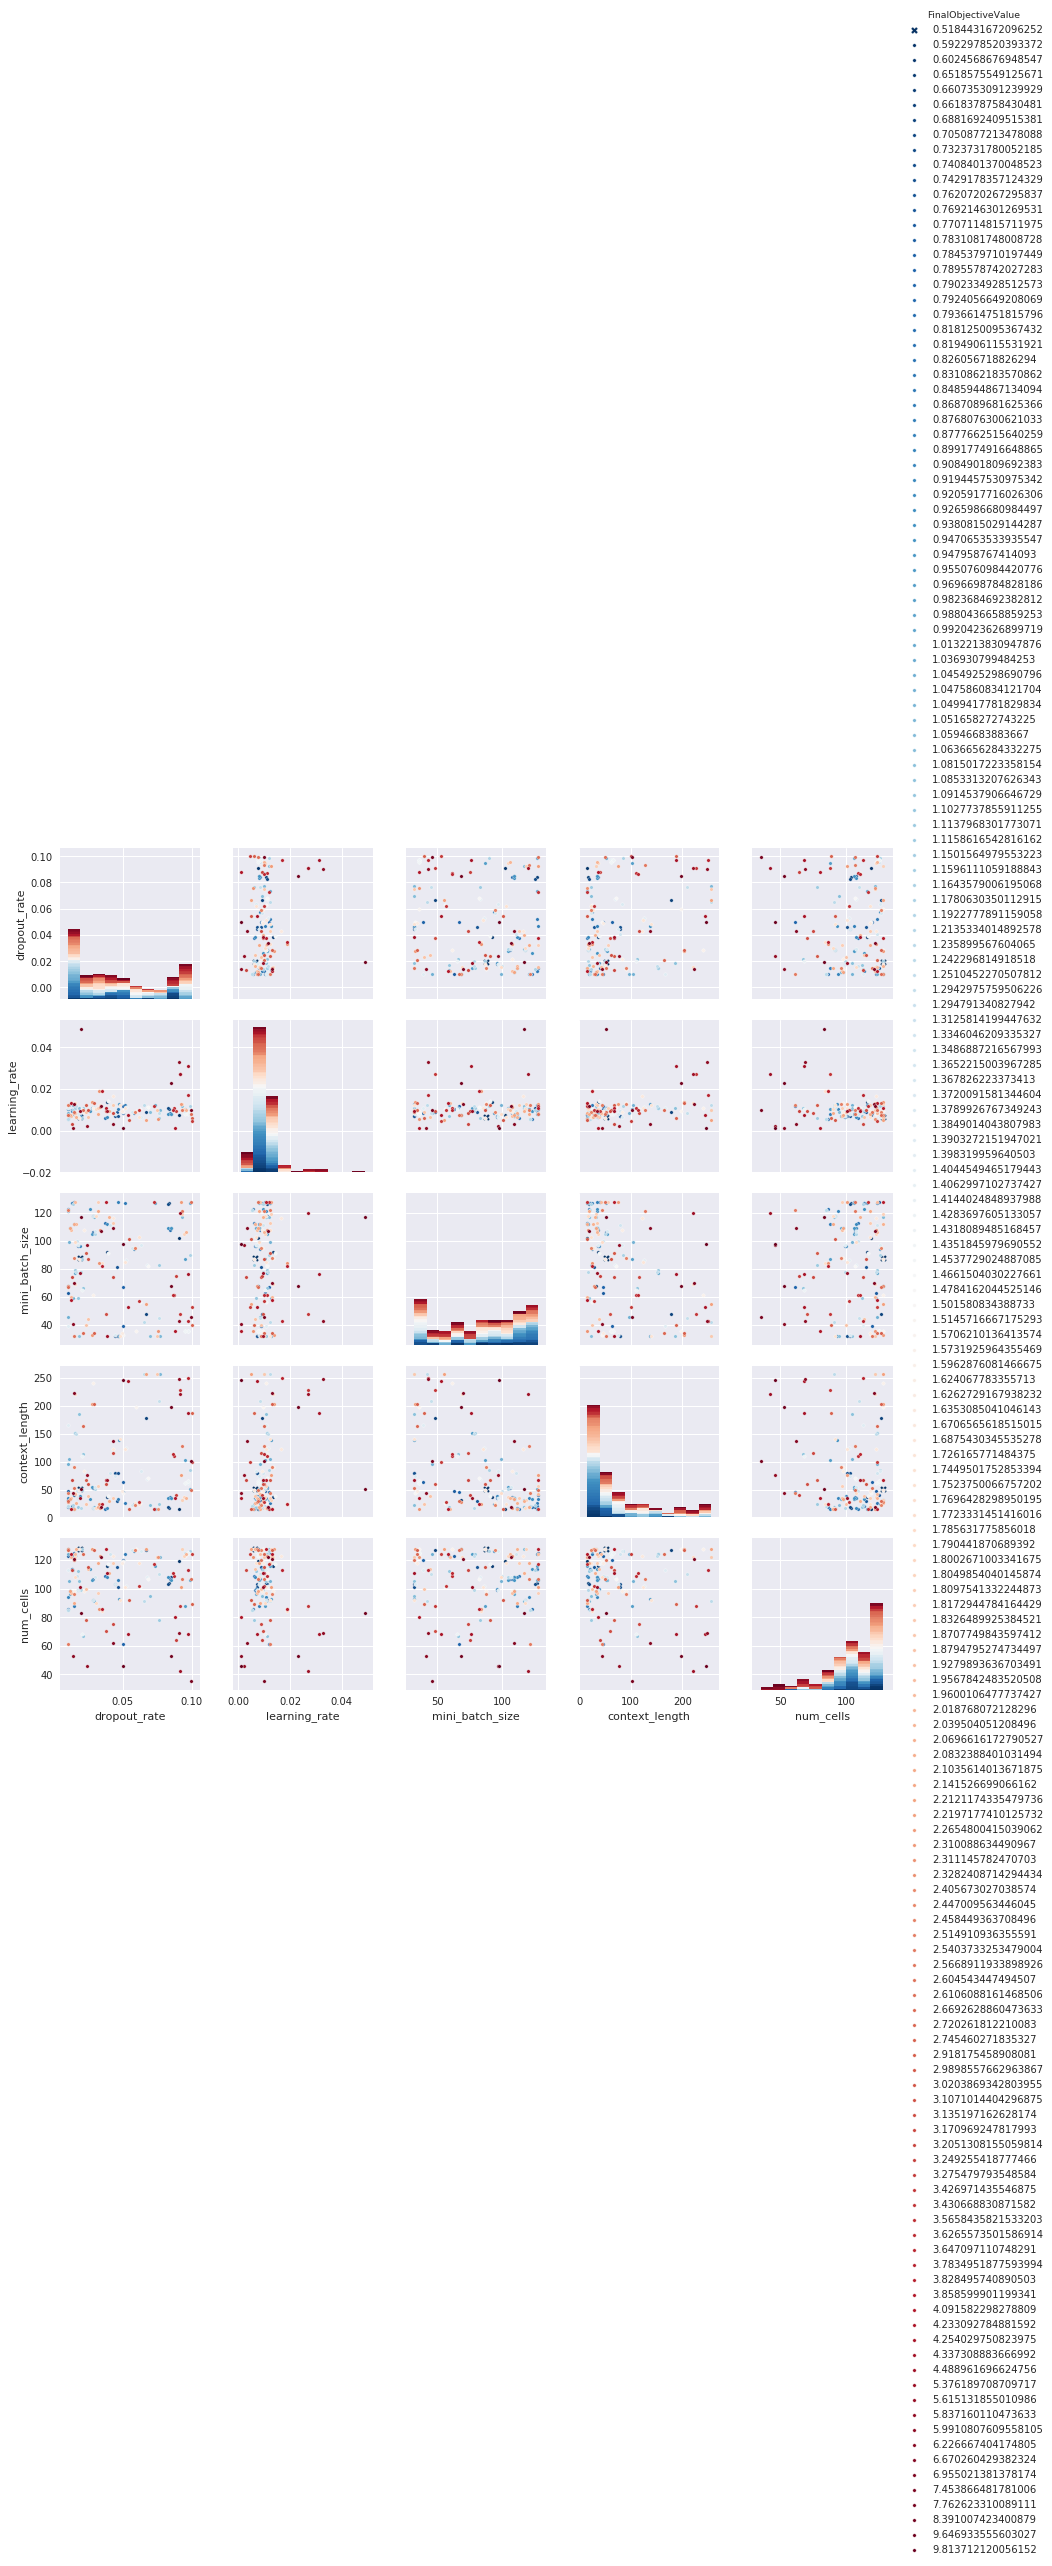

In [17]:
#print(tuner_iq._current_job_name)
analyze_ht_job('iq-200418-1628')

Number of training jobs and parameters searched 

context_length                121
dropout_rate                  183
learning_rate                 194
mini_batch_size                73
num_cells                      75
TrainingJobName               204
TrainingJobStatus               2
FinalObjectiveValue           111
TrainingStartTime             203
TrainingEndTime               201
TrainingElapsedTimeSeconds    169
dtype: int64

 



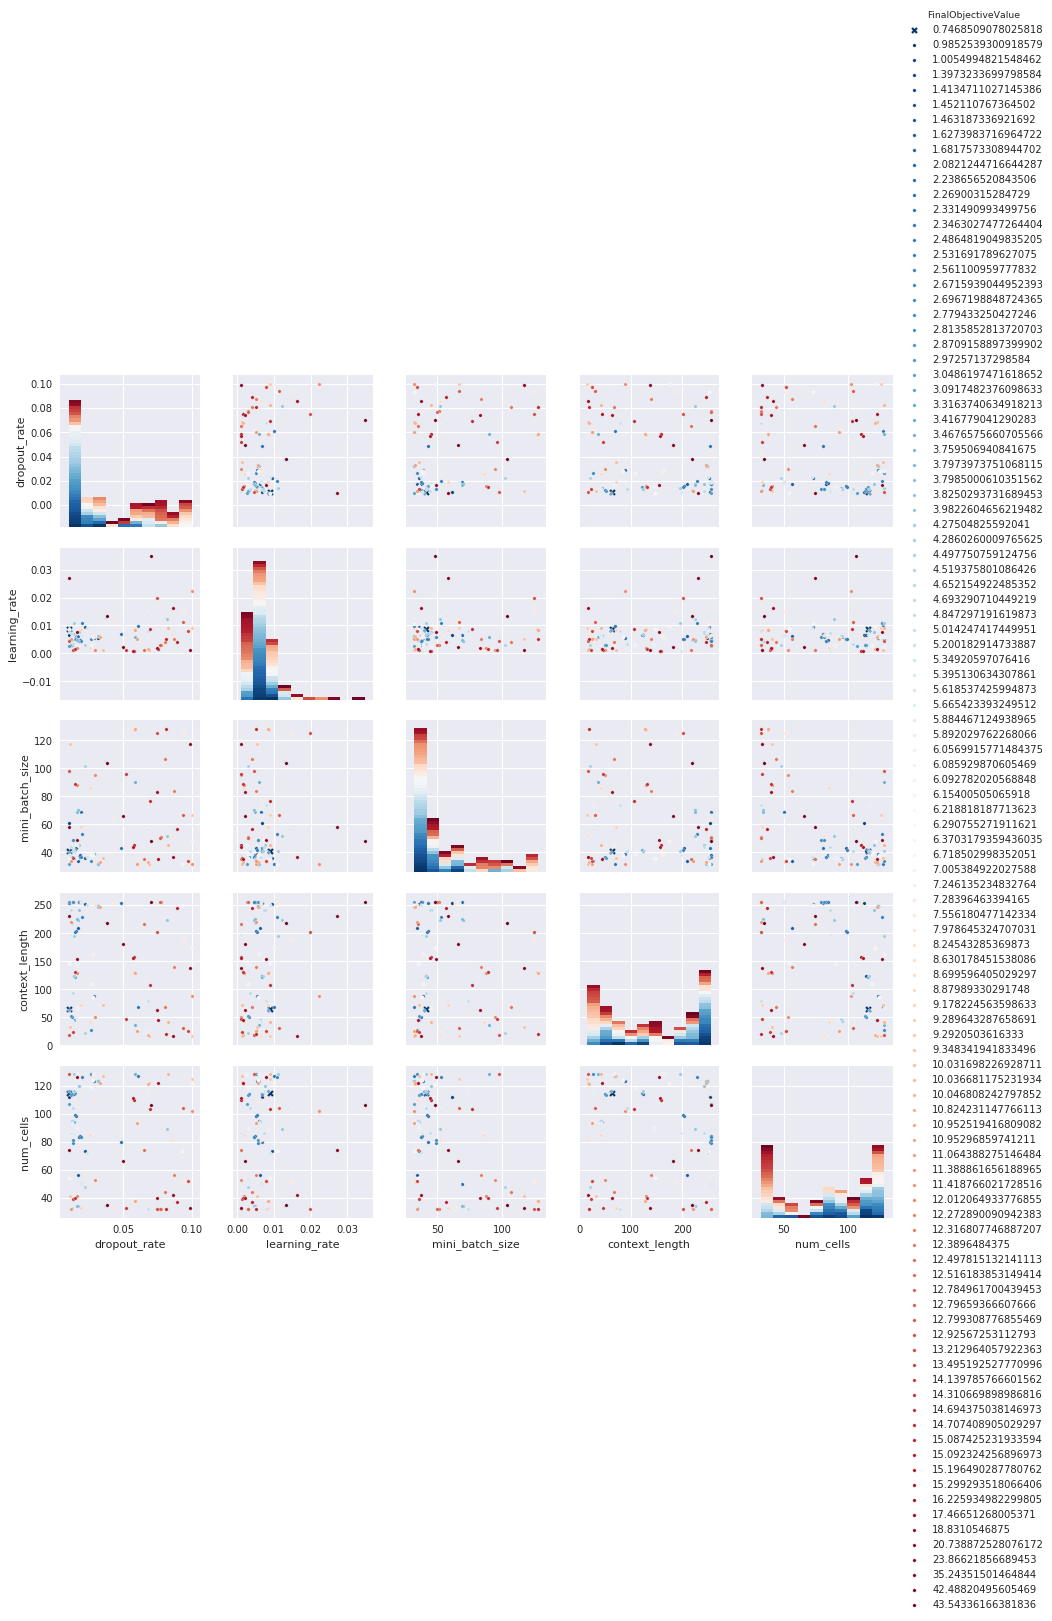

In [16]:
#print(tuner_iq._current_job_name)
analyze_ht_job('sj-200418-1628')